In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import emoji
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pandarallel import pandarallel
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter

pandarallel.initialize(nb_workers=8)
from settings import AMBIGUITY_CLUSTER
from src.data.utils import save_to_csv, parallelize_dataframe

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
pd.set_option('mode.chained_assignment', None)

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.5)
sns.set_style("white", {'axes.grid' : False})

### Calculate variances and a baseline

In [3]:
path = "/scratch/czestoch/bert_masked_emojis_embeddings_variances.csv.gz"
variances = pd.read_csv(path)
variances = variances[variances.emojis.isin(pd.read_csv(AMBIGUITY_CLUSTER).emoji.unique())]
variances.head()

,emojis,tweet
19,©️,1.673563
21,®️,1.943940
23,‼️,2.154577
25,⁉️,2.360315
27,™️,1.897762


In [6]:
variances.describe()

,tweet
count,945.000000
mean,2.042263
std,0.244498
min,0.470314
25%,1.891136
50%,2.032389
75%,2.181332
max,2.945991


In [8]:
from emoji import demojize
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM

In [3]:
def preprocess_tweets(group):
    emoji = group.emojis.unique()[0]
    if emoji == "*⃣" or emoji == '*️⃣':
        emoji = f"\{emoji}"
    try:
        group.tweet = group.tweet.apply(lambda x: x.replace(emoji, "[EMOJI]", 1))
        group.tweet = group.tweet.apply(demojize)
    except Exception:
        return np.nan
    return group

def get_embeddings_variance(group):
    try:
        encoded_input = tokenizer(group.tolist(), return_tensors='pt', padding=True, truncation=True)
        embeddings = model(**encoded_input)[1].detach().numpy()
        return np.sum(embeddings.var(0))
    except Exception:
        return np.nan

print("Load data...")
path = "/scratch/czestoch/sampled_tweets_bigger.txt.gz"
tweets = pd.read_csv(path, header=0, lineterminator='\n', encoding='utf-8')
tweets = tweets[tweets.emojis.isin(pd.read_csv(AMBIGUITY_CLUSTER).emoji.unique())]

# print("Preprocess tweets...")
# tweets = tweets.groupby("emojis").parallel_apply(preprocess_tweets)
# tweets = tweets.dropna()

# print("Load model...")
# tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",\
#                                         additional_special_tokens=["[EMOJI]"])
# model = AutoModel.from_pretrained("vinai/bertweet-base")
# model.resize_token_embeddings(len(tokenizer))

Load data...


In [7]:
baselines = []

for i in tqdm(range(1000)):
    sampled = tweets.sample(n=100, random_state=42+i)
    variance = get_embeddings_variance(sampled.tweet)
    baselines.append(variance)

alpha = 5    
baseline = np.nanmedian(np.array(baselines))
baselines_CIs = [np.nanpercentile(baselines, alpha / 2),\
                         np.nanpercentile(baselines, 100 - (alpha / 2))] 

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
print(baseline)
print(baselines_CIs)

2.1247587
[1.9261686623096468, 2.356197053194046]


In [7]:
variances = variances.rename({"emojis": "emoji", "tweet": "variance"}, axis=1)

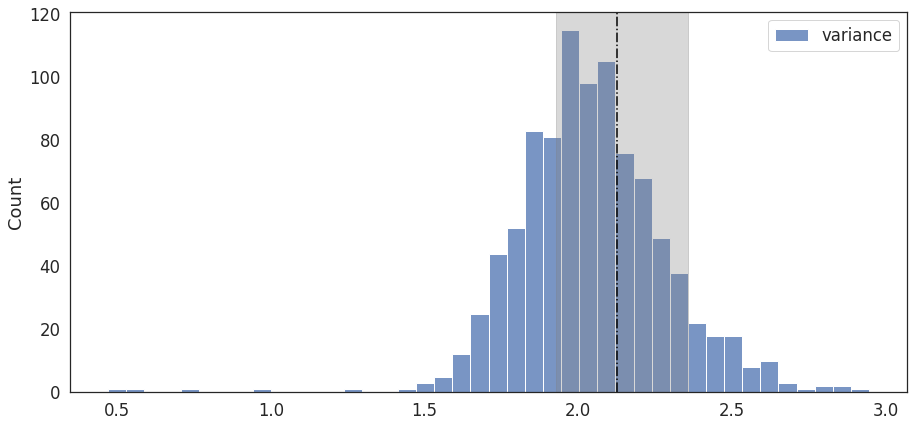

In [10]:
g = sns.histplot(variances)
g.axvline(baseline, linestyle="-.", color='black')
g.axvspan(baselines_CIs[0], baselines_CIs[1], alpha=0.3, color='gray')

In [11]:
variances[variances.emoji == '💁']

,emoji,variance
894,💁,1.768649


In [12]:
variances[variances.emoji == '🛂']

,emoji,variance


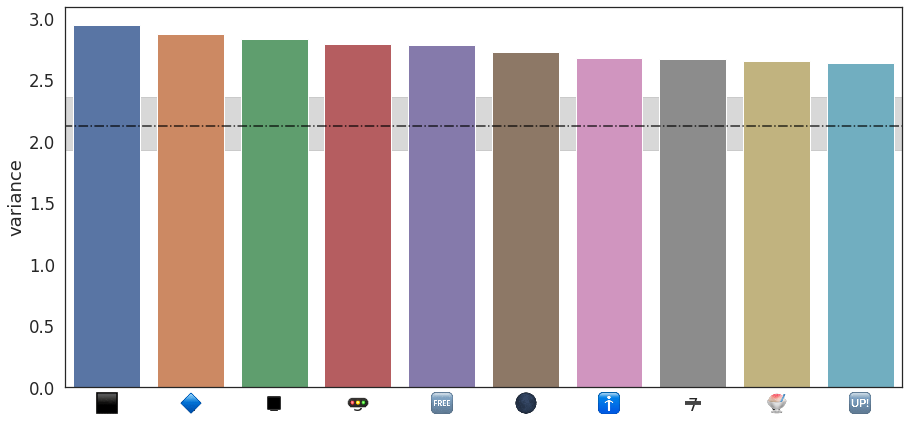

In [13]:
top_ten = variances.nlargest(10, columns='variance').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(top_ten, ax, col='variance', cluster=True)

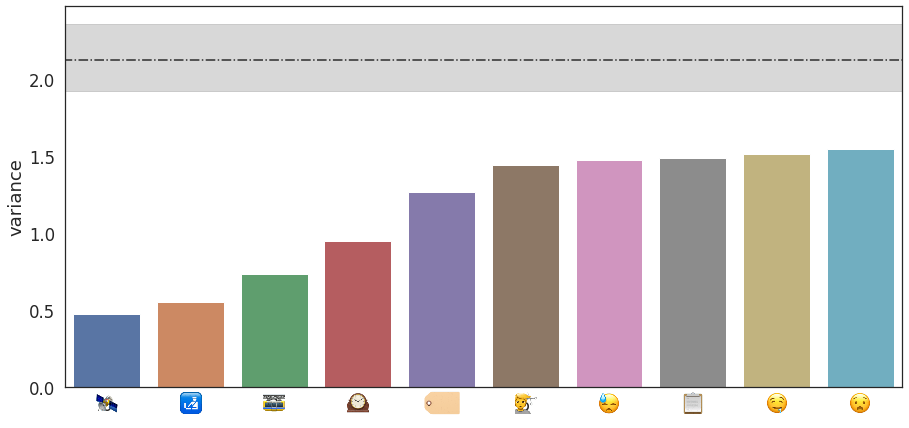

In [14]:
low_ten = variances.nsmallest(10, columns='variance').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(low_ten, ax, col='variance', cluster=True)

In [15]:
top_ten

,index,emoji,variance
0,246,⬛,2.945991
1,1101,🔷,2.871013
2,59,◾,2.829801
3,1369,🚥,2.789457
4,263,🆓,2.779139
5,386,🌑,2.727866
6,1396,🚹,2.675114
7,232,➖,2.672592
8,475,🍧,2.656491
9,267,🆙,2.634980


In [16]:
low_ten

,index,emoji,variance
0,1425,🛰️,0.470314
1,1404,🛃,0.551879
2,1366,🚟,0.734558
3,1128,🕰️,0.946908
4,649,🏷️,1.264654
5,935,💇,1.440570
6,1220,😓,1.477369
7,1010,📋,1.487269
8,1476,🤤,1.513752
9,1240,😧,1.544995


In [ ]:
## satellite - same tweet with different recommendation codes
## customs - I assume it's tagging users and also the isis warnings
## cable car - always two random words, seems like they come from the same account
## clock - stem summer camp, educational classes for kids - retweets of some commercial again
## label - always goes with panda for selling some different products also seems like from the same account

In [11]:
emoji = '😂'
for _, row in tweets[tweets.emojis==emoji].iterrows():
    print(row.tweet.replace("[EMOJI]", emoji))

Not much apparently 😂
Boy u wild 😂
😂😂 Sent this email to my teacher 😂😂😂😂 he called me into class a talked to me about it
Shit i post on social media for the public is NOT my situations 😂 stop tryna figure me out through tweets &amp; shit
This song is really for my freaky fan base 😂 Check it out now!
86400 seconds is a lot! 😂
BITCHHHHKWWKWKWKWMWNWDNSJQQWKWJEENESND LMFAOOOOOOOOOOOOO 😂😂😂😂😂😂😂😂😂😂😂
The lad tweets “see you all in half hour, don’t hide” Proceeds to hide by deleting his account 😂.
Yeah, you know how a lot of niggas want to live above their girls means. Now she has to pay for all that. 😂😂
yeah food sensitivities are soooo funny specially when you don’t have a choice 😂🤣🤣
What is this guy on 😂😂 his trade suggestions are ridiculous like why trade the farm system for a pla…
I hate when my grandma texts me .. she never makes any sense . Always skipping three words 😂🤣
40 Retweets To get daisy to go to prom with me 😂💯‼️
Brandon just texted me saying he wanted to be my girlfriend 😂😂😂😂😂😂

In [4]:
variation = pd.read_csv("/scratch/czestoch/ambiguity_variation.csv.gz")[["emoji", "variation"]]
variation.head()

,emoji,variation
0,#️⃣,0.496355
1,*️⃣,0.584016
2,©️,0.276658
3,®️,0.576165
4,‼️,0.494922


In [42]:
variances[variances.emoji == '©️']

,emoji,variance
19,©️,1.673563


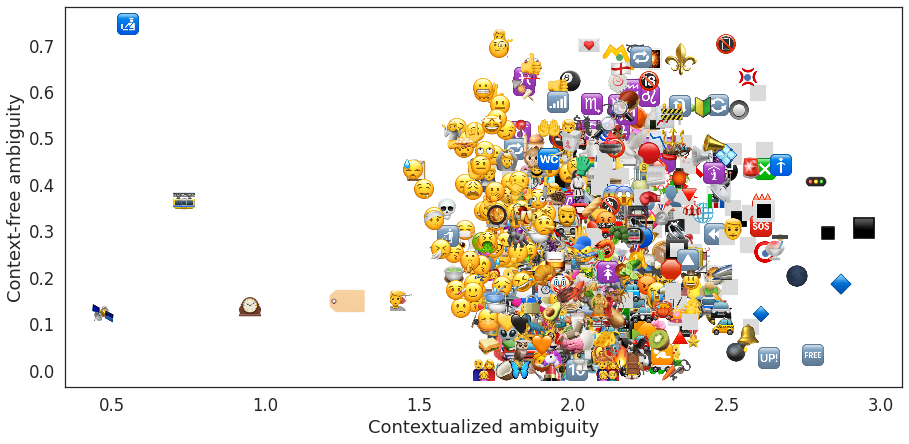

In [8]:
df = variances.merge(variation, on='emoji', how='left')
fig, ax = plt.subplots()
for x, y, emoji in zip(df['variance'], df['variation'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Contextualized ambiguity")
ax.set_ylabel("Context-free ambiguity");

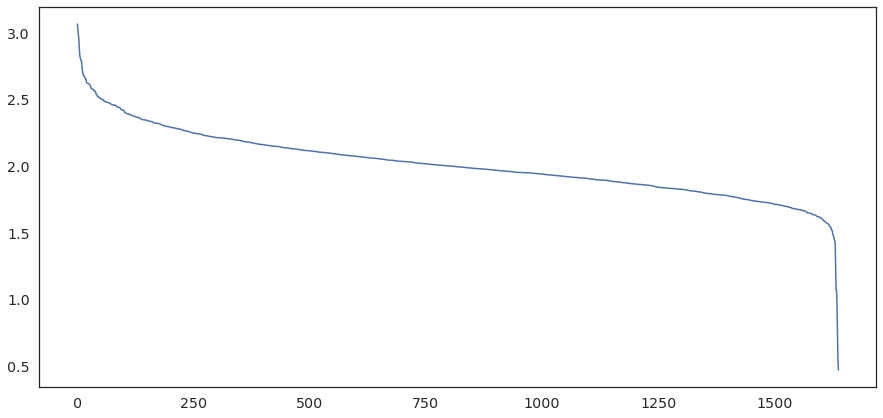

In [17]:
plt.plot(variances.sort_values("variance", ascending=False).variance.values)

In [ ]:
# path = "/scratch/czestoch/bert_emojis.csv.gz"
# path = "/scratch/czestoch/bert_emojis_masked.csv.gz"
# bert = pd.read_csv(path)

# # bert[bert.duplicated("tweet")]
# pd.set_option('display.max_colwidth', None)
# bert[bert.tweet == 'follow everyone who retweets this[EMOJI]'][["tweet", "emojis"]]
# # save_to_csv(bert, "/scratch/czestoch/bert_emojis_with_unknown_emojis.csv.gz")

# # masked emojis
# df = bert.groupby("emojis").tweet.count().sort_values().reset_index()
# df = df[df.emojis.isin(our_emojis)]
# rare_emojis = df[df.tweet<30].emojis.values
# bert = bert[bert.emojis.isin(our_emojis)]

# equalized = bert[~bert.emojis.isin(rare_emojis)]\
#                     .groupby("emojis").sample(n=30, random_state=42)
# equalized = pd.concat((bert[bert.emojis.isin(rare_emojis)], equalized))
# equalized.head()

# equalized.groupby("emojis").embedding.nunique().describe()

# df = equalized.groupby("emojis").embedding.nunique()
# equalized = equalized[equalized.emojis.isin(df[(equalized.groupby("emojis").embedding.nunique() >= 25)].index)]

# For emojis model was trained with
# equalized = bert.groupby("emoji").sample(n=30, random_state=42)

# # For all emojis version
# # eye in speech bubble has only 16 occurrences and all come from the same tweet, it's variance is 0 then
# equalized = bert[~bert.emoji.isin([":eye_in_speech_bubble_selector:", ":pause_button_selector:"])]\
#                     .groupby("emoji").sample(n=30, random_state=42)
# # pause button selector has only 28 occurrences so we add it here later
# equalized = pd.concat((bert[bert.emoji.isin([":pause_button_selector:"])], equalized))
# equalized = pd.concat((bert[bert.emoji.isin([":eye_in_speech_bubble_selector:"])], equalized))

# len(equalized)

# def calculate_variance(group):
#     ls = group.embedding.tolist()
#     matrix = np.array([eval(l) for l in ls])
#     if matrix.var(0).shape != (768,):
#         print(matrix.var(0).shape)
#     return np.sum(matrix.var(0))

# variances = equalized.groupby("emojis").parallel_apply(calculate_variance)

# variances.describe()

# baselines = []
# for i in tqdm(range(1000)):
# #     ls = bert.loc[equalized.tweet.drop_duplicates().sample(n=30).index].embedding.tolist()
#     ls = equalized.sample(n=30, random_state=42+i).embedding.tolist()
#     matrix = np.array([eval(l) for l in ls])
#     if matrix.var(0).shape != (768,):
#         print(matrix.var(0).shape)
#     variance = np.sum(matrix.var(0))
#     baselines.append(variance)

# alpha = 5    
# baseline = np.nanmedian(np.array(baselines))
# baselines_CIs = [np.nanpercentile(baselines, alpha / 2),\
#                          np.nanpercentile(baselines, 100 - (alpha / 2))] 

# baseline

# baselines_CIs

# # less than random
# variances[variances.variance < baselines_CIs[0]]

# variances = variances.reset_index()
# variances = variances.rename({0: "variance"}, axis=1)
# # variances.emojis = variances.emoji.parallel_apply(emojis.emojize)

# variances.head()

### Variances of softmax outputs

In [5]:
path = "/scratch/czestoch/softmax_emojis_variances_over_emoji_words.csv.gz"
variances = pd.read_csv(path)
variances = variances[variances.emojis.isin(pd.read_csv(AMBIGUITY_CLUSTER).emoji.unique())]
variances.head()

,emojis,tweet
0,©️,0.003143
1,®️,0.007534
2,‼️,0.006471
3,⁉️,0.005759
4,™️,0.020594


In [2]:
path = "/scratch/czestoch/sampled_tweets_bigger.txt.gz"
tweets = pd.read_csv(path, header=0, lineterminator='\n', encoding='utf-8')
tweets = tweets[tweets.emojis.isin(pd.read_csv(AMBIGUITY_CLUSTER).emoji.unique())]

def preprocess_tweets(group):
    emoji = group.emojis[0]
    if emoji == "*⃣" or emoji == '*️⃣':
        emoji = f"\{emoji}"
    try:
        group.tweet = group.tweet.apply(lambda x: x.replace(emoji, "<mask>", 1))
        group.tweet = group.tweet.apply(demojize)
    except Exception as e:
        return np.nan
    return group

def get_emoji_softmax_variance(texts):
    try:
        tokenized = [tokenizer.tokenize(text) for text in texts]
        tokenized = list(filter(lambda x: "<mask>" in x, tokenized))
        input_ = tokenizer(tokenized, return_tensors='pt', is_split_into_words=True, padding=True, truncation=True)
        mask_index = torch.where(input_["input_ids"] == tokenizer.mask_token_id)[1]
        output = model(**input_)
        logits = output.logits
        softmax = F.softmax(logits, dim=-1)
        over_our_words = softmax[torch.arange(softmax.size(0)), mask_index][:, indices].detach().numpy()
        return np.sum(np.var(over_our_words, 0))
    except Exception as e:
        print(e)
        return np.nan

from transformers import AutoTokenizer, AutoModelForMaskedLM

print("Load model...")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base")
model = AutoModelForMaskedLM.from_pretrained("vinai/bertweet-base")


from emoji import demojize
import torch
from torch.nn import functional as F
from tqdm.notebook import tqdm

vocab = list(tokenizer.encoder.keys())
our_words = set(pd.read_csv(AMBIGUITY_CLUSTER).word.unique())
indices = []
for vocab_idx, vocab_word in enumerate(vocab):
    if vocab_word in our_words:
        indices.append(vocab_idx)
indices = np.array(indices)

# baselines = []
# for i in tqdm(range(1000)):
#     sampled = tweets.sample(n=100, random_state=42+i)
#     texts = []
#     for _, row in sampled.iterrows():
#         emoji = row.emojis
#         if emoji == "*⃣" or emoji == '*️⃣':
#             emoji = f"\{emoji}"
#         masked = row.tweet.replace(emoji, "<mask>", 1)
#         texts.append(demojize(masked))
#     variance = get_emoji_softmax_variance(texts)
#     baselines.append(variance)

Load model...


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
alpha = 5    
baseline = np.nanmedian(np.array(baselines))
baselines_CIs = [np.nanpercentile(baselines, alpha / 2),\
                         np.nanpercentile(baselines, 100 - (alpha / 2))] 

In [23]:
print(baseline)
print(baselines_CIs)

0.006916965590789914
[0.0014715051627717914, 0.021851125080138437]


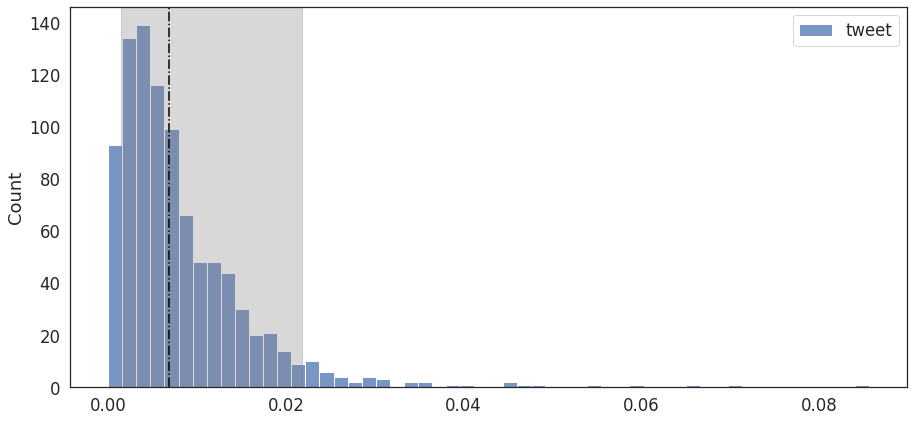

In [24]:
g = sns.histplot(variances)
g.axvline(baseline, linestyle="-.", color='black')
g.axvspan(baselines_CIs[0], baselines_CIs[1], alpha=0.3, color='gray')

In [25]:
variances.describe()

,tweet
count,925.000000
mean,0.008271
std,0.008145
min,0.000023
25%,0.003240
50%,0.006003
75%,0.011073
max,0.085564


In [51]:
variances[variances.emoji == '🛃']

,emoji,variance
803,🛃,0.000593


In [7]:
variances = variances.rename({"emojis": "emoji", "tweet": "variance"}, axis=1)

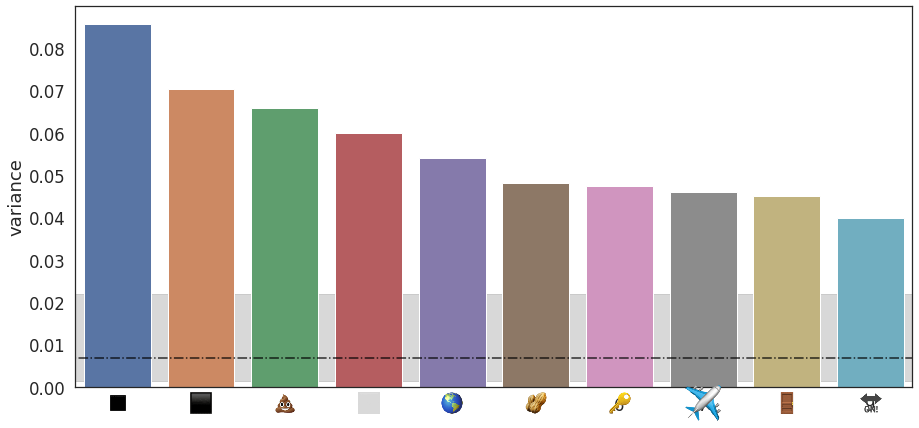

In [33]:
top_ten = variances.nlargest(10, columns='variance').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(top_ten, ax, col='variance', cluster=True)

In [28]:
top_ten

,index,emoji,variance
0,22,◼️,0.085564
1,124,⬛,0.070260
2,527,💩,0.065762
3,125,⬜,0.059849
4,156,🌎,0.054130
5,880,🥜,0.048065
6,612,🔑,0.047300
7,89,✈️,0.045945
8,785,🚪,0.044960
9,620,🔛,0.039825


In [43]:
path = "/scratch/czestoch/bert_masked_emojis_embeddings_variances.csv.gz"
embeddings_var = pd.read_csv(path)
embeddings_var = embeddings_var[embeddings_var.emojis.isin(pd.read_csv(AMBIGUITY_CLUSTER).emoji.unique())]
embeddings_var = embeddings_var.rename({"tweet": "embeddings_var", "emojis": "emoji"}, axis=1)
embeddings_var.head()

,emoji,embeddings_var
19,©️,1.673563
21,®️,1.943940
23,‼️,2.154577
25,⁉️,2.360315
27,™️,1.897762


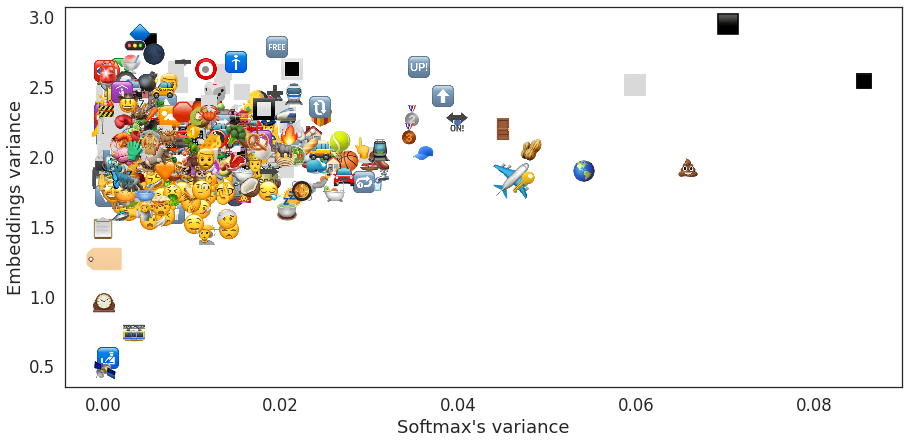

In [50]:
df = variances.merge(embeddings_var, on='emoji', how='left')
fig, ax = plt.subplots()
for x, y, emoji in zip(df['variance'], df['embeddings_var'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Softmax's variance")
ax.set_ylabel("Embeddings variance");

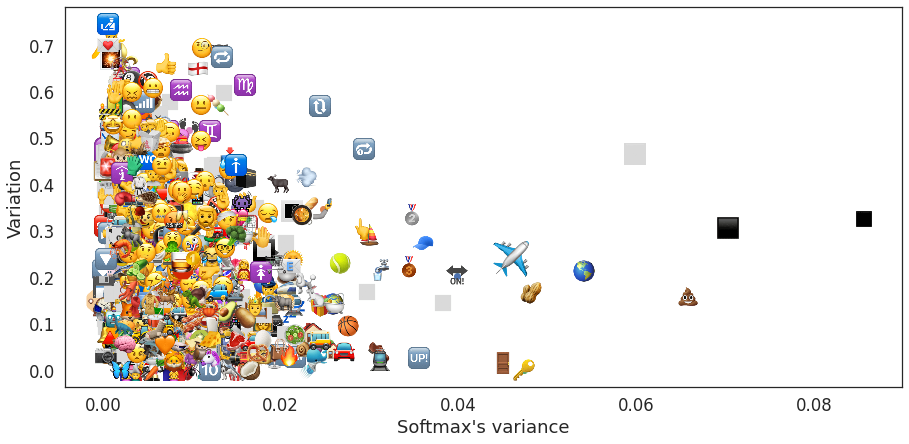

In [37]:
df = variances.merge(variation, on='emoji', how='left')
fig, ax = plt.subplots()
for x, y, emoji in zip(df['variance'], df['variation'], df['emoji']):
    emoji_scatter(x, y, emoji, zoom=0.3, ax=ax, cluster=True)
    ax.scatter(x, y)
ax.set_xlabel("Softmax's variance")
ax.set_ylabel("Variation");

In [60]:
for _, row in tweets[tweets.emojis == '◼️'].iterrows():
    print(row.tweet)

1ST ROUND ◼️MATCH 2 ◼️LEG 2 ▪️Listen to these R.E.M. songs ▪️Vote your fave (playlist below👇)
Your CR Ladycats play tonight @ 6:00 in Cross Roads against Martins Mill; be there or be ◼️
Had a great time at Purdue yesterday ◼️🔸😎
welcome to all the best for your time with us ◼️🔶🐺
you decide what you are, what you want to express by the way you dress and the way to live. ◼️…
BTS from a mastermindmedia production on our wonderful Black Stage ◼️
Follow everyone that LIKES THIS ◼️💎◼️ Follow👉 💎   TURN MY NOTIFICATION ON TO GAIN FOLLOW…
◼️🔺◽️Since all of Twitter is from Texas, I’d like to ask for my BBQ invites for this summer now so I can plan ahead. TH…
| Sound Nightclub ◼️▫️◼️
Oops forgot another one: ◼️Tether us to 5G for monitoring, tracking, and rating. Better hope you rate! NEW WORLD ORDER…
In that order ◼️◾️▪️
◼️✔︎◼️✔︎◼️✔︎◼️✔︎◼️✔︎◼️ NIKE/Hayward Futura Backpack ¥11,600+tax 📲
plz, rt ◼️I depend on you (os) ◼️Lucas &amp; Jungwoo x Jaemin   ◼️  🔗 https…
Hit that FOLLOW button! Updates and

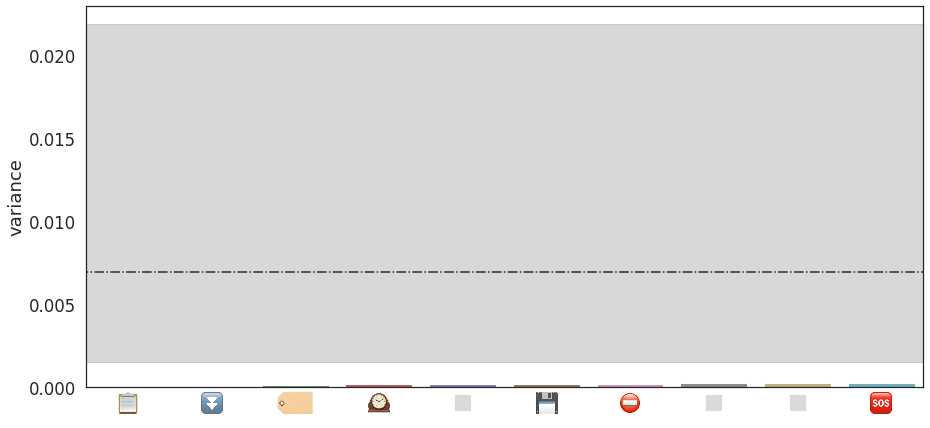

In [30]:
low_ten = variances.nsmallest(10, columns='variance').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(low_ten, ax, col='variance', cluster=True)

In [31]:
low_ten

,index,emoji,variance
0,558,📋,0.000023
1,13,⏬,0.000024
2,346,🏷️,0.000089
3,653,🕰️,0.000147
4,105,❇️,0.000159
5,547,💾,0.000160
6,79,⛔,0.000160
7,328,🏛️,0.000202
8,103,✴️,0.000211
9,139,🆘,0.000216


In [ ]:
for _, row in tweets[tweets.emojis == '🆘'].iterrows():
    print(row.tweet)

In [8]:
sampled = tweets.sample(n=30, random_state=42+0)

In [9]:
sampled

,tweet,emojis
71049,today's walwal wooh 🐺,🐺
50287,🎁Giveaway!🎁 Go to my Steam profile and leave a...,🎁
73406,It’s Anyone want to feel good about themselve...,👇
98673,Orgone energy 💱,💱
103920,"📯📣🎺🎯🎸📢🎳🎻〽️🎉🎤🎧🎼🎶 ""Godfada"" : 🎵▶️on / on your 📻",📯
43804,lucky cap 🍀,🍀
137740,🚭 World Famous Presents 🔞 ♨️ ♨️ From ♨️ ✅ ...,🚭
102073,This one goes out to the late night weekday cr...,📗
104007,MTUTD UPDATE 📰 Celio Santos calf/ankle injury ...,📰
56488,Follow me now and I will follow back immediate...,🏃


In [10]:
texts = []
for _, row in sampled.iterrows():
    emoji = row.emojis
    if emoji == "*⃣" or emoji == '*️⃣':
        emoji = f"\{emoji}"
    masked = row.tweet.replace(emoji, "<mask>", 1)
    texts.append(demojize(masked))

In [24]:
# print("Load model...")
# tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
# model = AutoModelForMaskedLM.from_pretrained("bert-base-cased")

In [16]:
import torch
from torch.nn import functional as F

In [42]:
vocab = list(tokenizer.encoder.keys())
our_words = set(pd.read_csv(AMBIGUITY_CLUSTER).word.unique())
indices = []
for vocab_idx, vocab_word in enumerate(vocab):
    if vocab_word in our_words:
        indices.append(vocab_idx)
indices = np.array(indices)

In [12]:
indices

array([    9,    11,    13, ..., 59454, 59636, 62752])

In [13]:
vocab[9]

'to'

In [4]:
ambiguity = pd.read_csv(AMBIGUITY_CLUSTER)

In [5]:
static_words = ambiguity[ambiguity.emoji == '🎶'].word.unique().tolist()

In [3]:
from tqdm.notebook import tqdm
from scipy.stats import entropy
from emoji import demojize

In [6]:
entropies_general = np.array([])
static_emojis = ambiguity.emoji.unique()
for current_emoji in tqdm(static_emojis):
    texts = []
    current_emoji_tweets = tweets[tweets.emojis == current_emoji]
    if not current_emoji_tweets.empty:
        emoji = current_emoji
        if emoji == "*⃣" or emoji == '*️⃣':
            emoji = f"\{emoji}"
        for _, row in current_emoji_tweets.iterrows():
            masked = row.tweet.replace(emoji, "<mask>", 1)
            texts.append(demojize(masked))

        try:
            tokenized = [tokenizer.tokenize(text) for text in texts]
            tokenized = list(filter(lambda x: "<mask>" in x, tokenized))
            input_ = tokenizer(tokenized, return_tensors='pt', is_split_into_words=True, padding=True, truncation=True)
            mask_index = torch.where(input_["input_ids"] == tokenizer.mask_token_id)[1]
            output = model(**input_)
            logits = output.logits
            softmax = F.softmax(logits, dim=-1)
            mask_word = softmax[torch.arange(softmax.size(0)), mask_index][:, indices].detach().numpy()
            entropies_general = np.append(entropies_general, entropy(mask_word, axis=1))
        except Exception as e:
            print(e)
            pass

  0%|          | 0/1325 [00:00<?, ?it/s]

shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: indexing tensors could not be broadcast together with shapes [100], [99]
shape mismatch: index

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-5e010e4948c2>", line 19, in <module>
    output = model(**input_)
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/czestoch/.local/lib/python3.7/site-packages/transformers/models/roberta/modeling_roberta.py", line 1060, in forward
    return_dict=return_dict,
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/home/czestoch/.local/lib/python3.7/site-packages/transformers/models/roberta/modeling_roberta.py", line 825, in forward
    return_dict=return_dict,
  File "/opt/anaconda3/lib/python3.7/site-packages/torch/nn/modules/module.py", line 889, in _call

KeyboardInterrupt: 

In [7]:
entropies_general.shape

(62700,)

In [8]:
np.mean(entropies_general)

4.28460447456808

In [9]:
np.std(entropies_general)

1.2948240000939415

In [10]:
np.min(entropies_general)

0.005268254317343235

In [11]:
np.max(entropies_general)

7.172973155975342

In [60]:
a = np.array([])
b = np.array([1,2,3,4,5,6])
a = np.append(a,b)
a

array([1., 2., 3., 4., 5., 6.])

In [65]:
b.shape

(6,)

In [63]:
a = np.append(a, [7,8,9,10,11,12])

In [64]:
a

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In [31]:
df = pd.Series(entropies).to_frame()
df.describe()

,0
count,925.000000
mean,4.238795
std,0.329884
min,3.120637
25%,4.052573
50%,4.261395
75%,4.439028
max,6.089338


In [35]:
df[df[0] == df[0].max()]

,0
🛃,6.089338


In [36]:
df[df[0] == df[0].min()]

,0
😪,3.120637


In [38]:
df.nlargest(10, 0)

,0
🛃,6.089338
🚟,5.905117
🏷️,5.686583
🛰️,5.653924
🆘,5.292668
💾,5.233910
🕰️,5.228674
🖌️,5.228619
🌆,5.101057
🔔,5.055151


In [39]:
df.nsmallest(10, 0)

,0
😪,3.120637
🤕,3.179228
🔃,3.233357
😓,3.238450
⏬,3.272848
😕,3.322632
😐,3.328955
🤞,3.349720
😒,3.361902
🙁,3.365600


<AxesSubplot:>

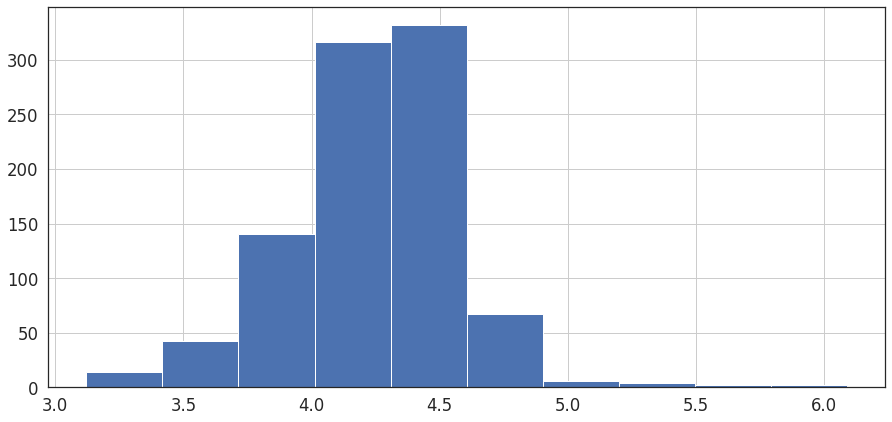

In [37]:
df[0].hist()

In [33]:
df[df[0] == df]

,0
©️,4.509030
®️,4.247935
‼️,3.864075
⁉️,3.879483
™️,4.362954
...,...
🧢,3.869887
🧣,4.405604
🧤,4.303997
🧥,4.344848


In [20]:
entropies

{}

In [12]:
df = pd.Series(how_many_in_top_100).to_frame()
df.describe()

,0
count,925.000000
mean,0.174714
std,0.094960
min,0.000000
25%,0.120000
50%,0.160000
75%,0.210000
max,0.780000


In [13]:
df[df[0] == 0.78]

,0
🎹,0.78


In [63]:
df = pd.Series(how_many_in_top_ten).to_frame()

In [64]:
df.head()

,0
©️,0.03
®️,0.04
‼️,0.01
⁉️,0.00
™️,0.02


In [65]:
df.describe()

,0
count,925.000000
mean,0.015708
std,0.024908
min,0.000000
25%,0.000000
50%,0.010000
75%,0.020000
max,0.250000


In [67]:
df[df[0] == 0.25]

,0
🎹,0.25


In [16]:
ambiguity[ambiguity.emoji == '🎹'].word

,WorkerID,FormId,Duration,emoji_index,emoji,word
10789,A3RIX2H2NYLNC4,41,271.0,378,🎹,piano
10790,A2HRUFTA09371Y,41,149.0,378,🎹,piano
10791,A1J1ZM062PH3FN,41,111.0,378,🎹,music
10792,A3KZEX1DDMXKDU,41,332.0,378,🎹,piano
10793,A2C7A6E70NYNUI,41,457.0,378,🎹,piano
10794,A337Y4X67PY4QI,41,132.0,378,🎹,piano
10795,A3OHYXTHW11HS7,41,405.0,378,🎹,piano
10796,A3EYRDEQ7CXUMN,41,233.0,378,🎹,music
10797,A2T1LNI80EPOQR,41,224.0,378,🎹,keyboard
10798,AT6LDQNLKTUSE,41,495.0,378,🎹,piano


In [59]:
how_many_in_top_ten

{'©️': 0.03,
 '®️': 0.04,
 '‼️': 0.01,
 '⁉️': 0.0,
 '™️': 0.02,
 'ℹ️': 0.01,
 '↔️': 0.01,
 '↗️': 0.0,
 '↘️': 0.0,
 '⌚': 0.0,
 '⌛': 0.0,
 '⏩': 0.0,
 '⏪': 0.03,
 '⏬': 0.0,
 '⏰': 0.03,
 '⏱️': 0.0,
 '⏲️': 0.01,
 '⏳': 0.02,
 'Ⓜ️': 0.03,
 '▪️': 0.0,
 '▫️': 0.03,
 '▶️': 0.02,
 '◼️': 0.02,
 '◽': 0.0,
 '◾': 0.03,
 '☀️': 0.01,
 '☁️': 0.01,
 '☂️': 0.0,
 '☃️': 0.0,
 '☄️': 0.02,
 '☎️': 0.0,
 '☑️': 0.0,
 '☔': 0.02,
 '☕': 0.04,
 '☘️': 0.01,
 '☝️': 0.01,
 '☠️': 0.0,
 '☢️': 0.02,
 '☣️': 0.02,
 '☪️': 0.01,
 '☮️': 0.01,
 '☯️': 0.0,
 '☹️': 0.0,
 '☺️': 0.01,
 '♈': 0.01,
 '♉': 0.0,
 '♊': 0.03,
 '♋': 0.01,
 '♍': 0.01,
 '♎': 0.01,
 '♏': 0.02,
 '♑': 0.01,
 '♒': 0.02,
 '♓': 0.01,
 '♠️': 0.01,
 '♣️': 0.0,
 '♥️': 0.0,
 '♦️': 0.03,
 '♨️': 0.02,
 '♻️': 0.0,
 '♿': 0.0,
 '⚒️': 0.0,
 '⚓': 0.02,
 '⚔️': 0.02,
 '⚖️': 0.02,
 '⚙️': 0.01,
 '⚛️': 0.02,
 '⚜️': 0.03,
 '⚠️': 0.05,
 '⚡': 0.03,
 '⚪': 0.0,
 '⚫': 0.0,
 '⚰️': 0.03,
 '⚽': 0.01,
 '⚾': 0.02,
 '⛄': 0.0,
 '⛅': 0.01,
 '⛈️': 0.03,
 '⛏️': 0.01,
 '⛔': 0.0,
 '⛪': 0.01,
 '⛳': 

In [50]:
tweets[tweets.emojis == '©️']

,tweet,emojis
1900,"| Harry with fans today! April 14, 2018 • ©️",©️
1901,[VID] Elyxion Tour- Monster in 2018: Kyungsoo ...,©️
1902,YUNHYEONG BOBBY AND DONGHYUK DANCING WITH THE ...,©️
1903,VIDEO || performing Just to See you Smile toni...,©️
1904,| Harry laughing on stage in Amsterdam tonight...,©️
...,...,...
1995,“Mandatory group photo after we wrap up shooti...,©️
1996,BTS Weibo update [TRANS] [ Heart Aim Shoot ♡ ...,©️
1997,| Harry performing Kiwi in Basel tonight March...,©️
1998,I challenge this Tweet to get to ten thousand ...,©️


In [48]:
tweets[tweets.emojis == '#️⃣']

,tweet,emojis


In [38]:
print("🎶")
non_empty = 0
for i, row in enumerate(top_10):
    print("ORIGINAL TWEET: ", emojize(texts[i]))
    print("MASKED: ", music.iloc[i].emojis)
    print()
    predicted = [tokenizer.decode([token]) for token in row]
    print(predicted)
    common = set(predicted).intersection(set(static_words))
    print(common)
    if common != set():
        non_empty+=1
    print()
    print("=======================================================")
print(non_empty / len(music))

🎶
ORIGINAL TWEET:  No one can stop me when I taste that feeling, Nothing could ever bring me down<mask>   https…
MASKED:  🎶

['like', 'to', 'love', 'that', 'and', 'anyway', 'this', 'here', 'either', 'a']
set()

ORIGINAL TWEET:  <mask>Bad boys, bad boys, whatcha gonna do? Whatcha gonna do when they come for you 🎶
MASKED:  🎶

['hey', 'singing', 'and', 'baby', 'ohh', 'ohhhh', 'song', 'like', 'o', 'em']
set()

ORIGINAL TWEET:  I knew I loved you then But you'd never know 'Cause I played it cool when I was scared of letting go <mask> x
MASKED:  🎶

['x', 'of', 'o', 'c', 'baby', 'forever', 'lol', 'on', 'love', 'to']
set()

ORIGINAL TWEET:  Take a little bit of my heart tonight <mask>
MASKED:  🎶

['baby', 'girl', 'boy', 'x', 'honey', 'lol', 'love', 'man', 'maybe', 'okay']
set()

ORIGINAL TWEET:  Who agrees? <mask> @ Munich, Germany
MASKED:  🎶

['or', 'and', 'v', 'x', 'vs', 'cc', 'to', 'm', 'o', 'n']
set()

ORIGINAL TWEET:  <mask> . 💖 DEADSET SOCIETY - Destroy + Rebuild (full album) via
MASKED:

In [16]:
from emoji import emojize

In [17]:
sampled.iloc[1]

tweet     🎁Giveaway!🎁 Go to my Steam profile and leave a...
emojis                                                    🎁
Name: 50287, dtype: object

In [40]:
# print("BERT BASE")
# print()
# for i, row in enumerate(top_10):
#     print("ORIGINAL TWEET: ", emojize(texts[i]))
#     print("MASKED: ", sampled.iloc[i].emojis)
#     print()
#     for token in row:
#         word = tokenizer.decode([token])
#         new_sentence = texts[i].repla`ce(tokenizer.mask_token, word)
#         print(new_sentence)
#         print()
#     print()
#     print("=======================================================")

In [20]:
for i, row in enumerate(top_10):
    print("ORIGINAL TWEET: ", emojize(texts[i]))
    print("MASKED: ", sampled.iloc[i].emojis)
    print()
    for token in row:
        word = tokenizer.decode([token])
        new_sentence = emojize(texts[i].replace(tokenizer.mask_token, word))
        print(new_sentence)
        print()
    print()
    print("=======================================================")

ORIGINAL TWEET:  today's walwal wooh <mask>
MASKED:  🐺

today's walwal wooh lol

today's walwal wooh wow

today's walwal wooh will

today's walwal wooh man

today's walwal wooh day

today's walwal wooh and

today's walwal wooh moo

today's walwal wooh to

today's walwal wooh wait

today's walwal wooh work


ORIGINAL TWEET:  <mask>Giveaway!🎁 Go to my Steam profile and leave a +rep comment. Who ever leaves the one I 💜 the most, wins this! Cheers! 2…
MASKED:  🎁

iGiveaway!🎁 Go to my Steam profile and leave a +rep comment. Who ever leaves the one I 💜 the most, wins this! Cheers! 2…

toGiveaway!🎁 Go to my Steam profile and leave a +rep comment. Who ever leaves the one I 💜 the most, wins this! Cheers! 2…

heyGiveaway!🎁 Go to my Steam profile and leave a +rep comment. Who ever leaves the one I 💜 the most, wins this! Cheers! 2…

helpGiveaway!🎁 Go to my Steam profile and leave a +rep comment. Who ever leaves the one I 💜 the most, wins this! Cheers! 2…

giftGiveaway!🎁 Go to my Steam profile and 

In [65]:
softmax.size()

torch.Size([30, 127, 64001])

In [71]:
softmax[torch.arange(softmax.size(0)), mask_index].size()

torch.Size([30, 64001])

In [ ]:
# variance = get_emoji_softmax_variance(texts)